<a href="https://colab.research.google.com/github/Untick/NetOptik/blob/main/Pogozhev%20Denis/NetOptic_materials_week_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Модель распознавания материалов.

За основу взят теоретический ноутбук занятия по сверточным нейронным сетям

##Создание и загрузка датасета.

В качестве датасета используются изображения из папок Металл, Пластик каталога TOTAL_folder, объединенные в отдельном каталоге NetOptic_datase на Google-диске.

Загрузка датасета в Colab и распаковка архива




In [ ]:
import gdown
gdown.download("https://drive.google.com/uc?id=1dQI-3P2cZn3xzBF91Pxx6Q9-J2vYFc50", "NetOptic.zip", quiet=True)


'NetOptic.zip'

In [ ]:
#Распаковка архива:
!unzip -qo "NetOptic.zip" -d /content/NetOptic_dataset

Загрузка сгенерированной части датасета - для каждого изображения и основной части датасета сгенерированы 10 дополнительных изображений. Для генерации используется библиотека  ImageDataGenerator

Для подготовки датасета необходимо:
1. Выполнить сортировку изображений путем создания списка файлов и списка меток. Выполняется отдельно для двух частей - основной и сгенерированной.
2. Выделение из основной части датасета тестовой выборки.
3. Выполнить нормализацию данных
4. Выполнить аугментацию данных
5. Разделить данные на обучающую, проверочную и тестовую выборки.


##Сортировка изображения. Создание списка файлов и списка меток


In [ ]:
import os
IMAGE_DIR = '/content/NetOptic_dataset/'
os.listdir(IMAGE_DIR)  # Список папок в директории


['Metall', 'Plastic']

In [ ]:
#Создание списка классов изображений
CLASS_LIST = sorted(os.listdir(IMAGE_DIR))
print(CLASS_LIST, type(CLASS_LIST))


['Metall', 'Plastic'] <class 'list'>


Для создания обучающей базы необходимо создать список всех изображений очков, отсортированных по материалам, а также список меток этих изображений. Метки должны быть в том же порядке, что и изображения.

In [ ]:
#Создаем списки для изображений и меток
data_image=[]
data_labels=[]

for l in range(2):   #перебираем в цикле для всех классов
  class_name = CLASS_LIST[l]
  class_path = IMAGE_DIR + class_name   #Полный путь к папке с изображениями
  class_file = os.listdir(class_path)   #Получение списка  имен файлов
  print(f'Класс {class_name} {len(class_file)} изображений')

  #Полученный полный путь к файлу с изображением добавляем в список изображений
  data_image += [f'{class_path}/{file_name}' for file_name in class_file]

  # Добавление ксписку меток текущего класса
  data_labels += [l] * len(class_file)

print(f"Общий размер базы {len(data_image)} изображений")



Класс Metall 418 изображений
Класс Plastic 499 изображений
Общий размер базы 917 изображений


In [ ]:
print(type(data_image))
print(data_image[10])

<class 'list'>
/content/NetOptic_dataset/Metall/grand-5653-c2-s2-2 (26).jpg



При помощи библиотеки PIL выведем изображение и его метку:
 0 - металл
 1 - пластик


In [ ]:
NUM_IMAGE = 556
data_image[NUM_IMAGE]

'/content/NetOptic_dataset/Plastic/gucci-gg3627-cs2-s2-1 (3).jpg'

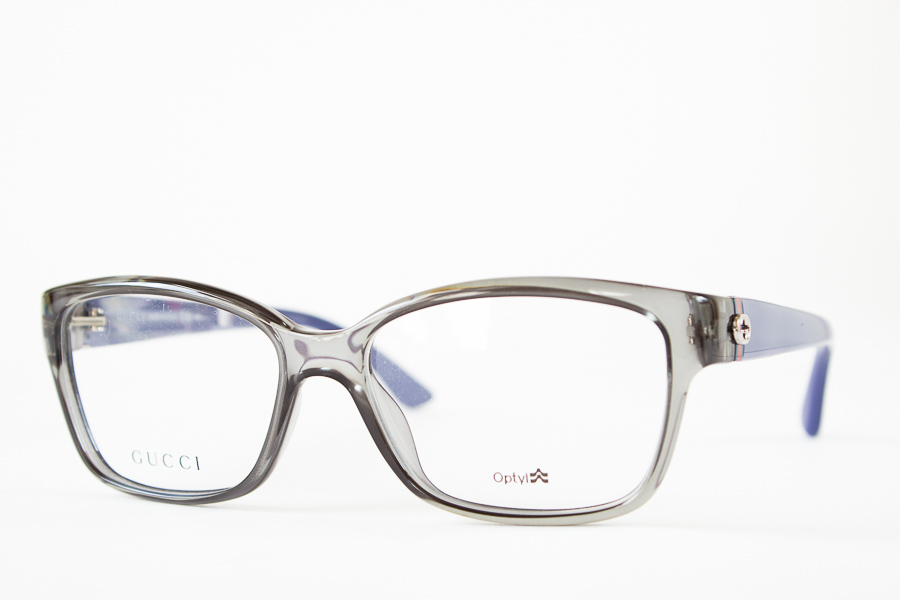

1


In [ ]:
from PIL import Image
from IPython.display import display

img = Image.open(data_image[NUM_IMAGE])
display(img)
print(data_labels[NUM_IMAGE])




## Выделение части изображений в тестовую выборку

In [ ]:
# Создание директорий для обучающей и тестовой выборки
os.mkdir('/content/NetOptic_test')
#os.mkdir('/content/NetOptic_train')

In [ ]:
# Перенос файлов для теста в отдельное дерево папок, расчет размеров наборов данных

#TRAIN_PATH = '/content/NetOptic_test'
TEST_PATH = '/content/NetOptic_test'
TEST_SPLIT = 0.2

# os.mkdir(TEST_PATH)                                        # Создание папки для тестовых данных
train_count = 0
test_count = 0

for class_name in CLASS_LIST:                              # Для всех классов по порядку номеров (их меток)
    class_path = f'{IMAGE_DIR}/{class_name}'              # Формирование полного пути к папке с изображениями класса
    #if not os.path.exists(class_path):
      #os.mkdir(class_path)
    test_path = f'{TEST_PATH}/{class_name}'                # Полный путь для тестовых данных класса
    if not os.path.exists(test_path):
      os.mkdir(test_path)
    class_files = os.listdir(class_path)                   # Получение списка имен файлов с изображениями текущего класса
    class_file_count = len(class_files)                    # Получение общего числа файлов класса
    # os.mkdir(test_path)                                    # Создание подпапки класса для тестовых данных
    test_file_count = int(class_file_count * TEST_SPLIT)   # Определение числа тестовых файлов для класса
    test_files = class_files[-test_file_count:]            # Выделение файлов для теста от конца списка
    for f in test_files:                                   # Перемещение тестовых файлов в папку для теста
        os.rename(f'{class_path}/{f}', f'{test_path}/{f}')
    train_count += class_file_count                        # Увеличение общего счетчика файлов обучающего набора
    test_count += test_file_count                          # Увеличение общего счетчика файлов тестового набора

    print(f'Размер класса {class_name}: {class_file_count} машин, для теста выделено файлов: {test_file_count}')

print(f'Общий размер базы: {train_count}, выделено для обучения: {train_count - test_count}, для теста: {test_count}')

Размер класса Metall: 418 машин, для теста выделено файлов: 83
Размер класса Plastic: 499 машин, для теста выделено файлов: 99
Общий размер базы: 917, выделено для обучения: 735, для теста: 182


##Генератроры изображений


Загрузка необходимых библиотек

In [ ]:
# Генератор аугментированных изображений
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Оптимизатор
from tensorflow.keras.optimizers import Adam

import numpy as np


Задание гиперпараметорв

In [ ]:
TEST_SPLIT          = 0.1                   # Доля тестовых данных в общем наборе
VAL_SPLIT           = 0.2                   # Доля проверочной выборки в обучающем наборе

IMG_WIDTH           = 256                   # Ширина изображения для нейросети
IMG_HEIGHT          = 128                    # Высота изображения для нейросети
IMG_CHANNELS        = 3                     # Количество каналов (для RGB равно 3, для Grey равно 1)
CLASS_COUNT = 2
# Параметры аугментации
ROTATION_RANGE      = 8                     # Пределы поворота
WIDTH_SHIFT_RANGE   = 0.15                  # Пределы сдвига по горизонтали
HEIGHT_SHIFT_RANGE  = 0.15                  # Пределы сдвига по вертикали
ZOOM_RANGE          = 0.15                  # Пределы увеличения/уменьшения
BRIGHTNESS_RANGE    = (0.7, 1.3)            # Пределы изменения яркости
HORIZONTAL_FLIP     = True                  # Горизонтальное отражение разрешено

EPOCHS              = 60                    # Число эпох обучения
BATCH_SIZE          = 24                    # Размер батча для обучения модели
OPTIMIZER           = Adam(0.0001)          # Оптимизатор

In [ ]:
# Изображения для обучающего набора нормализуются и аугментируются согласно заданным гиперпараметрам
# Далее набор будет разделен на обучающую и проверочную выборку в соотношении VAL_SPLIT
train_datagen = ImageDataGenerator(
                    rescale=1. / 255.,
                    rotation_range=ROTATION_RANGE,
                    width_shift_range=WIDTH_SHIFT_RANGE,
                    height_shift_range=HEIGHT_SHIFT_RANGE,
                    zoom_range=ZOOM_RANGE,
                    brightness_range=BRIGHTNESS_RANGE,
                    horizontal_flip=HORIZONTAL_FLIP,
                    validation_split=VAL_SPLIT
                )

# Изображения для тестового набора только нормализуются
test_datagen = ImageDataGenerator(
                   rescale=1. / 255.
                )

In [ ]:
# Обучающая выборка генерируется из папки обучающего набора
train_generator = train_datagen.flow_from_directory(
    # Путь к обучающим изображениям
    IMAGE_DIR,
    # Параметры требуемого размера изображения
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    # Размер батча
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    # Указание сгенерировать обучающую выборку
    subset='training'
)

# Проверочная выборка также генерируется из папки обучающего набора
validation_generator = train_datagen.flow_from_directory(
    IMAGE_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    # Указание сгенерировать проверочную выборку
    subset='validation'
)

# Тестовая выборка генерируется из папки тестового набора
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=test_count,
    class_mode='categorical',
    shuffle=True,
)

Found 588 images belonging to 2 classes.
Found 147 images belonging to 2 classes.
Found 182 images belonging to 2 classes.


In [ ]:
train_generator[0][0][0]
# (список пар изображений-меток)

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]], dtype=float32)

In [ ]:
# Проверка формы данных
print(f'Формы данных тренировочной выборки: {train_generator[0][0].shape}, {train_generator[0][1].shape}, батчей: {len(train_generator)}')
print(f'Формы данных   проверочной выборки: {validation_generator[0][0].shape}, {validation_generator[0][1].shape}, батчей: {len(validation_generator)}')
print(f'Формы данных      тестовой выборки: {test_generator[0][0].shape}, {test_generator[0][1].shape}, батчей: {len(test_generator)}')

Формы данных тренировочной выборки: (24, 128, 256, 3), (24, 2), батчей: 25
Формы данных   проверочной выборки: (24, 128, 256, 3), (24, 2), батчей: 7
Формы данных      тестовой выборки: (182, 128, 256, 3), (182, 2), батчей: 1


In [ ]:
x_train, y_train = train_generator[0]
print(x_train[0].shape)
print(x_train.shape)
print(y_train[0].shape)
print(y_train.shape)

(128, 256, 3)
(24, 128, 256, 3)
(2,)
(24, 2)


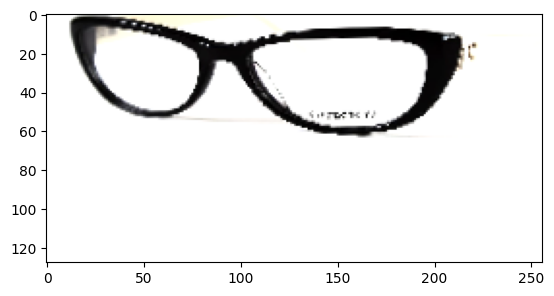

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(train_generator[5][0][2])
plt.show()

##Создание и обучение модели

In [ ]:
# Функция компиляции и обучения модели нейронной сети
# По окончанию выводит графики обучения

def compile_train_model(model,                  # модель нейронной сети
                        train_data,             # обучающие данные
                        val_data,               # проверочные данные
                        optimizer=OPTIMIZER,    # оптимизатор
                        epochs=EPOCHS,          # количество эпох обучения
                        batch_size=BATCH_SIZE,  # размер батча
                        figsize=(20, 5)):       # размер полотна для графиков

    # Компиляция модели
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Вывод сводки
    model.summary()

    # Обучение модели с заданными параметрами
    history = model.fit(train_data,
                        epochs=epochs,
                        # batch_size=batch_size,
                        validation_data=val_data)

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

In [ ]:
# Функция вывода результатов оценки модели на заданных данных

def eval_model(model,
               x,                # данные для предсказания модели (вход)
               y_true,           # верные метки классов в формате OHE (выход)
               class_labels=[],  # список меток классов
               cm_round=3,       # число знаков после запятой для матрицы ошибок
               title='',         # название модели
               figsize=(10, 10)  # размер полотна для матрицы ошибок
               ):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    ax.images[-1].colorbar.remove()       # Стирание ненужной цветовой шкалы
    fig.autofmt_xdate(rotation=45)        # Наклон меток горизонтальной оси
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    plt.show()

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

In [ ]:
# Совместная функция обучения и оценки модели нейронной сети

def compile_train_eval_model(model,                    # модель нейронной сети
                             train_data,               # обучающие данные
                             val_data,                 # проверочные данные
                             test_data,                # тестовые данные
                             class_labels=CLASS_LIST,  # список меток классов
                             title='',                 # название модели
                             optimizer=OPTIMIZER,      # оптимизатор
                             epochs=EPOCHS,            # количество эпох обучения
                             batch_size=BATCH_SIZE,    # размер батча
                             graph_size=(20, 5),       # размер полотна для графиков обучения
                             cm_size=(10, 10)          # размер полотна для матрицы ошибок
                             ):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(model,
                        train_data,
                        val_data,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(model, test_data[0][0], test_data[0][1],
               class_labels=class_labels,
               title=title,
               figsize=cm_size)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 256, 256)     7168      
                                                                 
 batch_normalization_3 (Batc  (None, 128, 256, 256)    1024      
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 256, 256)     590080    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 42, 85, 256)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 42, 85, 256)       590080    
                                                                 
 batch_normalization_4 (Batc  (None, 42, 85, 256)     

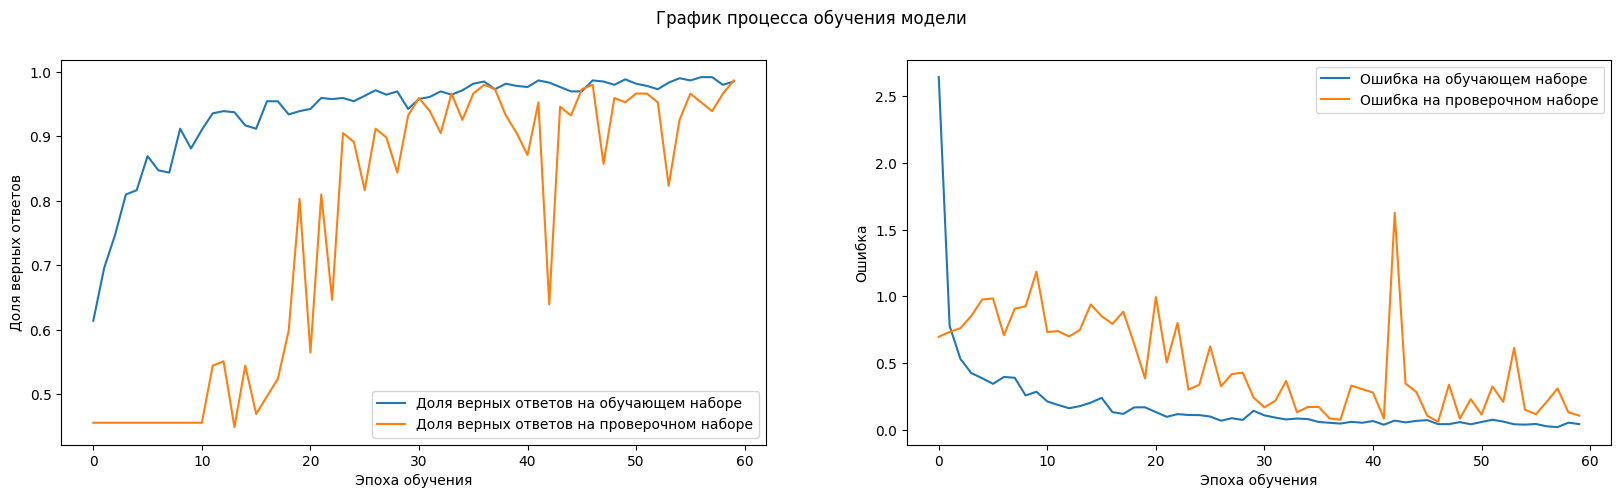

6/6 [==============================] - 13s 1s/step


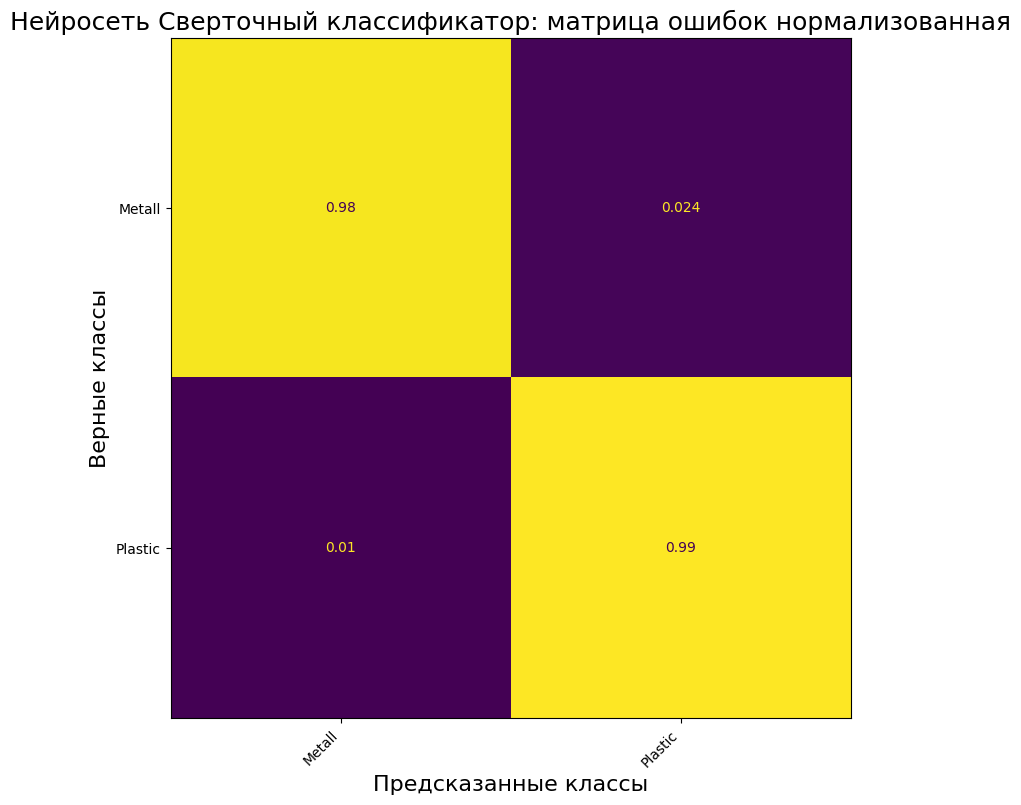

----------------------------------------------------------------------------------------------------
Нейросеть: Сверточный классификатор
Класс: Metall                98% сеть отнесла к классу Metall               - ВЕРНО :-)
Класс: Plastic               99% сеть отнесла к классу Plastic              - ВЕРНО :-)

Средняя точность распознавания:  98%


In [ ]:
# Основа для создания последовательной модели
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay




# Создание последовательной модели
model_conv = Sequential()

# Первый сверточный слой
model_conv.add(Conv2D(256, (3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
model_conv.add(BatchNormalization())

# Второй сверточный слой
model_conv.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(3, 3)))

# Третий сверточный слой
model_conv.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model_conv.add(BatchNormalization())
model_conv.add(Dropout(0.2))

# Четвертый сверточный слой
model_conv.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(3, 3)))
model_conv.add(Dropout(0.2))

# Пятый сверточный слой
model_conv.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model_conv.add(BatchNormalization())

# Шестой сверточный слой
model_conv.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(3, 3)))
model_conv.add(Dropout(0.2))

# Слой преобразования многомерных данных в одномерные
model_conv.add(Flatten())

# Промежуточный полносвязный слой
model_conv.add(Dense(2048, activation='relu'))

# Промежуточный полносвязный слой
model_conv.add(Dense(4096, activation='relu'))

# Выходной полносвязный слой с количеством нейронов по количесту классов
model_conv.add(Dense(CLASS_COUNT, activation='softmax'))


# Обучение модели и вывод оценки ее работы на тестовых данных
compile_train_eval_model(model_conv,
                         train_generator,
                         validation_generator,
                         test_generator,
                         class_labels=CLASS_LIST,
                         title='Сверточный классификатор')